In [2]:
from google.oauth2 import service_account
from google.cloud import storage
import nibabel as nib
import os
import pandas as pd
import tensorflow as tf
import gcsfs
import random
from nilearn import image
import numpy as np

/Users/tobiasbraun/anaconda3/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [3]:
#change path
file_path = '/Users/tobiasbraun/Documents/Studium USA/Columbia University/Semester 3/Deep Learning/Codes/Project/'
api_key = file_path + "deep-learning-255016-4350337ed6f4.json"
credentials = service_account.Credentials.from_service_account_file(api_key)
client = storage.Client(credentials=credentials, project="deep-learning")

In [4]:
fs = gcsfs.GCSFileSystem(token=api_key, project="deep-learning")
with fs.open('mri_data_bucket/ADNI_t1_list_with_fsstatus_20190111.csv') as f:
    df = pd.read_csv(f)

df.to_csv('labels.csv')

In [6]:
bucket_name = "mri_data_bucket"
bucket = client.get_bucket(bucket_name)
prefix = "data"

In [10]:
bucket = client.get_bucket(bucket_name)
blobs = bucket.list_blobs(prefix=prefix)

file_names_list = []
for blob in blobs:
        file_names_list.append(blob.name)


In [11]:
def _int64_feature(value):
    return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))

def _float_feature(value):
    return tf.train.Feature(float_list=tf.train.FloatList(value=value))

def _bytes_feature(value):
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))


In [12]:
labels=df[['Subject','T1.SERIESID','Group']].copy()

labels=labels[(labels.Group == 'CN')|(labels.Group == 'AD')]#|(labels.Group == 'EMCI')|(labels.Group == 'LMCI')|(labels.Group == 'MCI')]

labels['new_ind']=labels['Subject']+"_"+labels['T1.SERIESID'].astype(str)
labels.loc[labels.Group == 'CN','Group']=0
labels.loc[labels.Group == 'AD','Group']=1
labels.loc[labels.Group == 'EMCI','Group']=2
labels.loc[labels.Group == 'LMCI','Group']=3
labels.loc[labels.Group == 'MCI','Group']=4
labels = labels.set_index('new_ind')
labels=labels.drop(columns=['Subject','T1.SERIESID'])

labels.shape

(4307, 1)

In [8]:
#file_names=file_names
#file_names_list
#len(file_names_list)

In [9]:
import re
pattern1 = re.compile(r'S\d+')
pattern2 = re.compile(r'\d+_S_\d+')

In [10]:
# def download(file_names):
#     count=0
#     for filename in file_names:
#         filename=filename[5:]
#         try:
#             series_id = re.search(pattern1, filename).group(0)[1:]
#             subject = re.search(pattern2,filename).group(0)
#             ind=subject+"_"+series_id

#             label=labels.loc[ind,'Group']          
#             blob = bucket.blob('data/'+filename)
#             blob.download_to_filename('data/'+filename)
#             count+=1

#             if count % 100 ==0:
#                 print(count)
#         except:
#             continue
# download(file_names_list)

In [10]:
def normalise(file_names):
    count=0

    min_x,min_y,min_z=np.ones(156**2)*np.inf,np.ones(156**2)*np.inf,np.ones(156**2)*np.inf
    max_x,max_y,max_z=np.zeros(156**2),np.zeros(156**2),np.zeros(156**2)

    for filename in file_names:
        filename=filename[5:]
        try:
            image_ = nib.load('data/'+filename)
            image = image_.get_data()
            x=image[127,50:206,50:206]#,:,:]#,50:206,50:206]
            x=np.array(x.ravel())
            
            y=image[50:206,127,50:206]#[:,127,:]#[50:206,127,50:206]
            y=np.array(y.ravel())
            
            z=image[50:206,50:206,127]#[:,:,127]#
            z=np.array(z.ravel())
                       
            min_x=np.amin(np.array([min_x,x]), axis=0)
            min_y=np.amin(np.array([min_y,y]), axis=0)
            min_z=np.amin(np.array([min_z,z]), axis=0)
            
            max_x=np.amax(np.array([max_x,x]), axis=0)
            max_y=np.amax(np.array([max_y,y]), axis=0)
            max_z=np.amax(np.array([max_z,z]), axis=0)
            count+=1
            if count % 100 ==0:
                print(count)
        except:
            continue
            
    min_ = [min_x, min_y, min_z]
    max_ = [max_x, max_y, max_z]
    return min_, max_

In [11]:
min_flat, max_flat = normalise(file_names_list)

100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200


In [ ]:
# for filename in file_names_list[7:10]:
#     filename=filename[5:]
    
#     image_ = nib.load('data/'+filename)
#     print('a')

#     image = image_.get_data()

#     x=image[127,:,:]#[127,50:216,50:216]
#     x=np.array(x.ravel())

#     y=image[:,127,:]#[50:216,127,50:216]
#     y=np.array(y.ravel())

#     z=image[5:,:,127]#[50:216,50:216,127]
#     z=np.array(z.ravel())

#     min_x=np.amin(np.array([min_x,x]), axis=0)
#     min_y=np.amin(np.array([min_y,y]), axis=0)
#     min_z=np.amin(np.array([min_z,z]), axis=0)

#     max_x=np.amax(np.array([max_x,x]), axis=0)
#     max_y=np.amax(np.array([max_y,y]), axis=0)
#     max_z=np.amax(np.array([max_z,z]), axis=0)
#     count+=1

In [ ]:
np.save('Normalizing_files/min_flat_x_156',min_flat[0])
np.save('Normalizing_files/max_flat_x_156',max_flat[0])

np.save('Normalizing_files/min_flat_y_156',min_flat[1])
np.save('Normalizing_files/max_flat_y_156',max_flat[1])

np.save('Normalizing_files/min_flat_z_156',min_flat[2])
np.save('Normalizing_files/max_flat_z_156',max_flat[2])

In [ ]:
min_flat_x = np.load('Normalizing_files/min_flat_x_156.npy')
max_flat_x = np.load('Normalizing_files/max_flat_x_156.npy')

min_flat_y = np.load('Normalizing_files/min_flat_y_156.npy')
max_flat_y = np.load('Normalizing_files/max_flat_y_156.npy')

min_flat_z = np.load('Normalizing_files/min_flat_z_156.npy')
max_flat_z = np.load('Normalizing_files/max_flat_z_156.npy')

In [ ]:
import re
pattern1 = re.compile(r'S\d+')
pattern2 = re.compile(r'\d+_S_\d+')

In [ ]:
file_names=pd.DataFrame()
for filename in file_names_list:
    row=dict()
    row['filename']=filename[5:]
    filename=filename[5:]
    try:
        series_id = re.search(pattern1, filename).group(0)[1:]
        subject = re.search(pattern2,filename).group(0)
        ind=subject+"_"+series_id
        row['ind']=ind
        row['label']=labels.loc[ind,'Group'] 
    except:
        row['ind']= 'No label'
        row['label']= 'No label'   
    file_names=file_names.append(row,ignore_index=True)

file_names = file_names[file_names['ind']!='No label']
file_names[:20]

,filename,ind,label
1,002_S_0295_S110476-T1_T1_brain_mni305.nii,002_S_0295_110476,0
2,002_S_0295_S13408_T1_brain_mni305.nii,002_S_0295_13408,0
3,002_S_0295_S150055-T1_T1_brain_mni305.nii,002_S_0295_150055,0
4,002_S_0295_S21856_T1_brain_mni305.nii,002_S_0295_21856,0
5,002_S_0295_S32678_T1_brain_mni305.nii,002_S_0295_32678,0
6,002_S_0295_S54061_T1_brain_mni305.nii,002_S_0295_54061,0
7,002_S_0295_S67612_T1_brain_mni305.nii,002_S_0295_67612,0
8,002_S_0295_S84944_T1_brain_mni305.nii,002_S_0295_84944,0
10,002_S_0413_S111992-T1_T1_brain_mni305.nii,002_S_0413_111992,0
11,002_S_0413_S13893_T1_brain_mni305.nii,002_S_0413_13893,0


In [ ]:
# shuffle table:
file_names = file_names.sample(frac=1)

In [ ]:
cut = int(len(file_names)/10)

testing_file_names = file_names[:cut]
validation_file_names = file_names[cut:2*cut]
training_file_names = file_names[2*cut:]

Class 0: 2419
Class 1: 1001
Proportion: 2.42 : 1


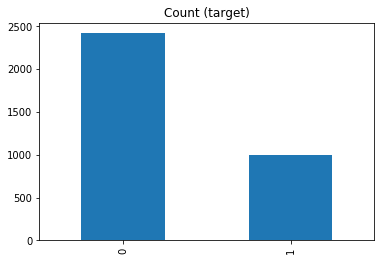

In [ ]:
target_count = training_file_names.label.value_counts()
print('Class 0:', target_count[0])
print('Class 1:', target_count[1])
# print('Class 2:', target_count[2])
# print('Class 3:', target_count[3])
# print('Class 4:', target_count[4])
print('Proportion:', round(target_count[0] / target_count[1], 2), ': 1')

target_count.plot(kind='bar', title='Count (target)')

In [ ]:
# Class count
count_class_0, count_class_1 = training_file_names.label.value_counts() #, count_class_2, count_class_3, count_class_4

# Divide by class
df_class_0 = training_file_names[training_file_names['label'] == 0]
df_class_1 = training_file_names[training_file_names['label'] == 1]
# df_class_2 = training_file_names[training_file_names['label'] == 2]
# df_class_3 = training_file_names[training_file_names['label'] == 3]
# df_class_4 = training_file_names[training_file_names['label'] == 4]

Random over-sampling:
1    2419
0    2419
Name: label, dtype: int64


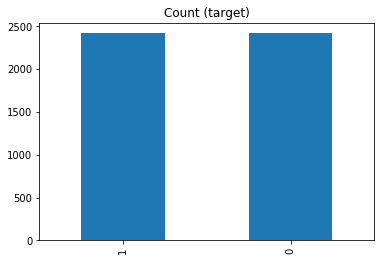

In [ ]:
df_class_1_over = df_class_1.sample(count_class_0, replace=True)
# df_class_2_over = df_class_2.sample(count_class_0, replace=True)
# df_class_3_over = df_class_3.sample(count_class_0, replace=True)
# df_class_4_over = df_class_4.sample(count_class_0, replace=True)
training_file_names_over = pd.concat([df_class_0, df_class_1_over], axis=0) #df_class_2_over, df_class_3_over, df_class_4_over]

print('Random over-sampling:')
print(training_file_names_over.label.value_counts())
training_file_names_over.label.value_counts().plot(kind='bar', title='Count (target)')

In [ ]:
training_file_names_over = training_file_names_over.sample(frac=1).reset_index(drop=True)
training_file_names_over[:10]

,filename,ind,label
0,005_S_6084_S618192_T1_brain_mni305.nii,005_S_6084_618192,0
1,016_S_0991_S21736_T1_brain_mni305.nii,016_S_0991_21736,1
2,133_S_1170_S24674_T1_brain_mni305.nii,133_S_1170_24674,1
3,005_S_1341_S27673_T1_brain_mni305.nii,005_S_1341_27673,1
4,036_S_4491_S182085_T1_brain_mni305.nii,036_S_4491_182085,0
5,027_S_6582_S734730_T1_brain_mni305.nii,027_S_6582_734730,0
6,116_S_0392_S15287_T1_brain_mni305.nii,116_S_0392_15287,1
7,036_S_6179_S653392_T1_brain_mni305.nii,036_S_6179_653392,1
8,099_S_0372_S13671_T1_brain_mni305.nii,099_S_0372_13671,1
9,032_S_0677_S123773_T1_brain_mni305.nii,032_S_0677_123773,0


In [ ]:
training_file_names_over.to_csv('training_file_names_over.csv')
testing_file_names.to_csv('testing_file_names.csv')
validation_file_names.to_csv('validation_file_names.csv')

In [ ]:
def write_tfrecords(save_filename,file_names,min_,max_):
    i=0
    writer = tf.python_io.TFRecordWriter(save_filename)
    for index, row in file_names.iterrows():
        filename=row['filename']
        label=int(row['label'])
        name=str.encode(row['ind'])
        try:
            image_ = nib.load('data/'+filename)
            crop_image = image_.get_data()
            im=crop_image[127,50:206,50:206]#,:,:]
            normalized_im=(im.ravel()-min_)/(max_+0.0001-min_)
            feature = {'label': _int64_feature(label),
                   'image': _float_feature(normalized_im),
                     'name': _bytes_feature(name)}
            # Create an example protocol buffer - Protocol buffers are a cross-platform, 
            #    cross-language library for efficient serialization of structured data.
            example = tf.train.Example(features=tf.train.Features(feature=feature))
            # Serialize to string and write on the file
            writer.write(example.SerializeToString())
            i+=1
            if i%50==0:
                print('i: ',i)
        except:
            continue

    writer.close()


In [ ]:
write_tfrecords('training_flat_x_156.tfrecords',training_file_names_over,min_flat_x,max_flat_x)
write_tfrecords('testing_flat_x_156.tfrecords',testing_file_names,min_flat_x,max_flat_x)
write_tfrecords('validation_flat_x_156.tfrecords',validation_file_names,min_flat_x,max_flat_x)

i:  50
i:  100
i:  150
i:  200
i:  250
i:  300
i:  350
i:  400
i:  450
i:  500
i:  550
i:  600
i:  650
i:  700
i:  750
i:  800
i:  850
i:  900
i:  950
i:  1000
i:  1050
i:  1100
i:  1150
i:  1200
i:  1250
i:  1300
i:  1350
i:  1400
i:  1450
i:  1500
i:  1550
i:  1600
i:  1650
i:  1700
i:  1750
i:  1800
i:  1850
i:  1900
i:  1950
i:  2000
i:  2050
i:  2100
i:  2150
i:  2200
i:  2250
i:  2300
i:  2350
i:  2400
i:  2450
i:  2500
i:  2550
i:  2600
i:  2650
i:  2700
i:  2750
i:  2800
i:  2850
i:  2900
i:  2950
i:  3000
i:  3050
i:  3100
i:  3150
i:  3200
i:  3250
i:  3300
i:  3350
i:  3400
i:  3450
i:  3500
i:  3550
i:  3650
i:  3700
i:  3750
i:  3800
i:  3900
i:  3950
i:  4000
i:  4050
i:  4100
i:  4150
i:  4200
i:  4250
i:  4300
i:  4350
i:  4400
i:  4450
i:  4500
i:  4550
i:  4600
i:  4650
i:  4700
i:  4800
i:  50
i:  100
i:  150
i:  250
i:  300
i:  350
i:  400
i:  50
i:  100
i:  150
i:  200
i:  250
i:  300
i:  350
i:  400


In [26]:
def write_tfrecords(save_filename,file_names,min_,max_):
    AD=0
    i=0
    writer = tf.python_io.TFRecordWriter(save_filename)
    for index, row in file_names.iterrows():
        filename=row['filename']
        label=int(row['label'])
        name=str.encode(row['ind'])
        try:
            image_ = nib.load('data/'+filename)
            crop_image = image_.get_data()
            im=crop_image[:,127,:]#[50:206,127,50:206]
            normalized_im=(im.ravel()-min_)/(max_+0.0001-min_)
            feature = {'label': _int64_feature(label),
                   'image': _float_feature(normalized_im),
                     'name': _bytes_feature(name)}
            # Create an example protocol buffer - Protocol buffers are a cross-platform, 
            #    cross-language library for efficient serialization of structured data.
            example = tf.train.Example(features=tf.train.Features(feature=feature))
            # Serialize to string and write on the file
            writer.write(example.SerializeToString())
            i+=1
            if i%50==0:
                print('i: ',i)
        except:
            continue

    writer.close()



In [27]:
write_tfrecords('training_flat_y_156_full_dataset.tfrecords',training_file_names_over,min_flat_y,max_flat_y)
write_tfrecords('testing_flat_y_156_full_dataset.tfrecords',testing_file_names,min_flat_y,max_flat_y)
write_tfrecords('validation_flat_y_156_full_dataset.tfrecords',validation_file_names,min_flat_y,max_flat_y)

i:  50
i:  100
i:  150
i:  200
i:  250
i:  300
i:  350
i:  400
i:  450
i:  500
i:  550
i:  600
i:  650
i:  700
i:  750
i:  800
i:  850
i:  900
i:  950
i:  1000
i:  1050
i:  1100
i:  1150
i:  1200
i:  1250
i:  1300
i:  1350
i:  1400
i:  1450
i:  1500
i:  1550
i:  1600
i:  1650
i:  1700
i:  1750
i:  1800
i:  1850
i:  1900
i:  1950
i:  2000
i:  2050
i:  2100
i:  2150
i:  2200
i:  2250
i:  2300
i:  2350
i:  2400
i:  2450
i:  2500
i:  2550
i:  2600
i:  2650
i:  2700
i:  2750
i:  2800
i:  2850
i:  2900
i:  2950
i:  3000
i:  3050
i:  3100
i:  3150
i:  3200
i:  3250
i:  3300
i:  3350
i:  3400
i:  3450
i:  3500
i:  3550
i:  3600
i:  3650
i:  3700
i:  3750
i:  3800
i:  3850
i:  3900
i:  3950
i:  4000
i:  4050
i:  4100
i:  4150
i:  4200
i:  4250
i:  4300
i:  4350
i:  4400
i:  4450
i:  4500
i:  4550
i:  4600
i:  4650
i:  4700
i:  4750
i:  4800
i:  50
i:  100
i:  150
i:  200
i:  250
i:  300
i:  350
i:  400
i:  50
i:  100
i:  150
i:  200
i:  250
i:  300
i:  350
i:  400


In [28]:
def write_tfrecords(save_filename,file_names,min_,max_):
    AD=0
    i=0
    writer = tf.python_io.TFRecordWriter(save_filename)
    for index, row in file_names.iterrows():
        filename=row['filename']
        label=int(row['label'])
        name=str.encode(row['ind'])
        try:
            image_ = nib.load('data/'+filename)
            crop_image = image_.get_data()
            im=crop_image[:,:,127]#[50:206,50:206,127]
            normalized_im=(im.ravel()-min_)/(max_+0.0001-min_)
            feature = {'label': _int64_feature(label),
                   'image': _float_feature(normalized_im),
                     'name': _bytes_feature(name)}
            # Create an example protocol buffer - Protocol buffers are a cross-platform, 
            #    cross-language library for efficient serialization of structured data.
            example = tf.train.Example(features=tf.train.Features(feature=feature))
            # Serialize to string and write on the file
            writer.write(example.SerializeToString())
            i+=1
            if i%50==0:
                print('i: ',i)
        except:
            continue

    writer.close()



In [29]:
write_tfrecords('training_flat_z_156_full_dataset.tfrecords',training_file_names_over,min_flat_z,max_flat_z)
write_tfrecords('testing_flat_z_156_full_dataset.tfrecords',testing_file_names,min_flat_z,max_flat_z)
write_tfrecords('validation_flat_z_156_full_dataset.tfrecords',validation_file_names,min_flat_z,max_flat_z)

i:  50
i:  100
i:  150
i:  200
i:  250
i:  300
i:  350
i:  400
i:  450
i:  500
i:  550
i:  600
i:  650
i:  700
i:  750
i:  800
i:  850
i:  900
i:  950
i:  1000
i:  1050
i:  1100
i:  1150
i:  1200
i:  1250
i:  1300
i:  1350
i:  1400
i:  1450
i:  1500
i:  1550
i:  1600
i:  1650
i:  1700
i:  1750
i:  1800
i:  1850
i:  1900
i:  1950
i:  2000
i:  2050
i:  2100
i:  2150
i:  2200
i:  2250
i:  2300
i:  2350
i:  2400
i:  2450
i:  2500
i:  2550
i:  2600
i:  2650
i:  2700
i:  2750
i:  2800
i:  2850
i:  2900
i:  2950
i:  3000
i:  3050
i:  3100
i:  3150
i:  3200
i:  3250
i:  3300
i:  3350
i:  3400
i:  3450
i:  3500
i:  3550
i:  3600
i:  3650
i:  3700
i:  3750
i:  3800
i:  3850
i:  3900
i:  3950
i:  4000
i:  4050
i:  4100
i:  4150
i:  4200
i:  4250
i:  4300
i:  4350
i:  4400
i:  4450
i:  4500
i:  4550
i:  4600
i:  4650
i:  4700
i:  4750
i:  4800
i:  50
i:  100
i:  150
i:  200
i:  250
i:  300
i:  350
i:  400
i:  50
i:  100
i:  150
i:  200
i:  250
i:  300
i:  350
i:  400


In [ ]:
# # # all files 
# file_names=file_names_list

# # sample filenames:
# training_file_names=[]
# validation_file_names=[]
# testing_file_names=[]
# for filename in file_names:
#     u=np.random.rand()
#     if u<0.7:
#         training_file_names.append(filename)
#     elif (u>0.7)&(u<0.85):
#         validation_file_names.append(filename)
#     else:
#         testing_file_names.append(filename)
# write_tfrecords('training_80.tfrecords',training_file_names)
# write_tfrecords('validation_80.tfrecords',validation_file_names)
# write_tfrecords('testing_80.tfrecords',testing_file_names)

In [ ]:
# # first 2000 files 
# file_names=file_names_list[1:2001]
# # sample filenames:
# training_file_names=[]
# validation_file_names=[]
# testing_file_names=[]
# for filename in file_names:
#     u=np.random.rand()
#     if u<0.7:
#         training_file_names.append(filename)
#     elif (u>0.7)&(u<0.85):
#         validation_file_names.append(filename)
#     else:
#         testing_file_names.append(filename)

# write_tfrecords('training_80_small.tfrecords',training_file_names)
# write_tfrecords('validation_80_small.tfrecords',validation_file_names)
# write_tfrecords('testing_80_small.tfrecords',testing_file_names)

In [ ]:
# train_filename = 'training_80_small.tfrecords'
# validation_filename= 'validation_80_small.tfrecords'
# testing_filename='testing_80_small.tfrecords'
# # open the file
# i=0
# AD=0
# CN=0
# train_i=0
# test_i=0
# val_i=0

# for filename in file_names:
#     filename=filename[5:]
#     u=np.random.rand()
    
#     if u<0.7:
#         writer = tf.python_io.TFRecordWriter(train_filename)
#     elif (u>0.7)&(u<0.85):
#         writer = tf.python_io.TFRecordWriter(validation_filename)
#     else:
#         writer = tf.python_io.TFRecordWriter(testing_filename)  
        
#     try:
#         series_id = re.search(pattern1, filename).group(0)[1:]
#         subject = re.search(pattern2,filename).group(0)
#         ind=subject+"_"+series_id

#         label=labels.loc[ind,'Group']
# #         if label==1:
# #             label=[0,1]
# #         else:
# #             label=[1,0]

#         if label==1:
#             AD+=1
#         else:
#             CN+=1
         
#         blob = bucket.blob('data/'+filename)
#         blob.download_to_filename('data_temp/'+filename)
#         image_ = nib.load('data_temp/'+filename)
#         crop_image = image.image._crop_img_to(image_,[slice(88,168),slice(88,168),slice(88,168)])
#         feature = {'train/label': _int64_feature(label),
#                'train/image': _float_feature(crop_image.get_data().ravel())}

#         # Create an example protocol buffer - Protocol buffers are a cross-platform, 
#         #    cross-language library for efficient serialization of structured data.
#         example = tf.train.Example(features=tf.train.Features(feature=feature))
#         # Serialize to string and write on the file
#         writer.write(example.SerializeToString())
#         os.remove('data_temp/'+filename)
#         i+=1
        
#         if u<0.7:
#             train_i+=1
#             print('train',train_i)
#         elif (u>0.7)&(u<0.85):
#             val_i+=1
#             print('val',val_i)
#         else:
#             test_i+=1
#             print('test',test_i)
#         print('AD: ',AD)
#         print('CN: ',CN)
#     except:
#         continue
# print('AD: ',AD)
# print('CN: ',CN)

# writer.close()